# Reversal rate analysis
<hr>
## Import necessary modules

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as mpatch
from matplotlib.collections import PatchCollection
from matplotlib import cm
import pandas as pd
#from IPython.core.display import HTML
import numpy as np
import scipy as sp
from scipy import stats
import random
import main_fncs as mf

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

<hr>
## Import data

First we import the geomagnetic polarity timescale from the 2016 Geologic Time Scale (J.G. Ogg, G.M. Ogg, and F.M. Gradstein, 2016; also see [the Timescale Creator website](https://engineering.purdue.edu/Stratigraphy/tscreator/index/index.php)). The data file is formatted so that each chron is defined by a base (oldest) and a top (youngest) age. The duration of the chron is computed in the last column.

In [3]:
gpts = pd.read_csv('gpts.csv')
gpts.head()

,Top (Ma),Base (Ma),Duration (myr)
0,0.000,0.781,0.781
1,0.781,0.988,0.207
2,0.988,1.072,0.084
3,1.072,1.173,0.101
4,1.173,1.185,0.012


Next, we import the PINT paleointensity database. Before making use of these data, we need to make a few changes to the imported dataframe. These changes include 1) excluding studies in which only no virtual dipole moment (VDM) was calculated and 2) converting VDM values to the proper magnitude. To make these modifications, we use the `format_PINT` function within the `main_funcs.py` module provided in this repository.

In [4]:
PINT_data_table = pd.read_csv('PINT.csv')
PINT_database = mf.format_PINT(PINT_data_table)

Finally, we create separate dataframes for the PINT database with different $Q_{PI}$ criteria applied (Biggin and Paterson, 2014). The naming scheme for these dataframes is such that `PINT_STAT1` represents all entries of the PINT database for which STAT=1, etc.

In [5]:
# apply QPI criteria
PINT_STAT1 = mf.apply_QPI(PINT_database, 'stat')
PINT_ALT1 = mf.apply_QPI(PINT_database, 'alt')
PINT_STAT1_ALT1 = mf.apply_QPI(PINT_database, 'stat', 'alt')

<hr>
## Background on paleointensity and reversal rates

***TODO: Some background on the historical observations that have motivated this and other studies. Refer to the well-known reversal rate vs paleointensity plot below***

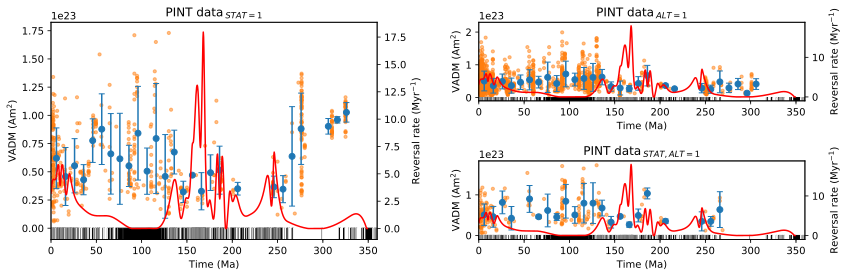

In [6]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2, colspan=1)
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
ax5 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)
#fig, ax1 = plt.subplots(figsize=(10,6))
pint_del_t = 10
for age in range(1, 350, pint_del_t):
    vdms = PINT_STAT1.loc[(PINT_STAT1.AGE>=age)&(PINT_STAT1.AGE<age+pint_del_t)]['VDM/VADM']
    ax1.errorbar(age+(pint_del_t/2), vdms.mean(), yerr=vdms.std(), fmt='o', capsize=3, ecolor='C0')
    vdms = PINT_ALT1.loc[(PINT_ALT1.AGE>=age)&(PINT_ALT1.AGE<age+pint_del_t)]['VDM/VADM']
    ax3.errorbar(age+(pint_del_t/2), vdms.mean(), yerr=vdms.std(), fmt='o', capsize=3, ecolor='C0')
    vdms = PINT_STAT1_ALT1.loc[(PINT_STAT1_ALT1.AGE>=age)&(PINT_STAT1_ALT1.AGE<age+pint_del_t)]['VDM/VADM']
    ax5.errorbar(age+(pint_del_t/2), vdms.mean(), yerr=vdms.std(), fmt='o', capsize=3, ecolor='C0')
ax1.scatter(PINT_STAT1.loc[PINT_STAT1.AGE>1.]['AGE'], PINT_STAT1.loc[PINT_STAT1.AGE>1.]['VDM/VADM'],c='C1', s=10, alpha=0.5)
ax3.scatter(PINT_ALT1.loc[PINT_ALT1.AGE>1.]['AGE'], PINT_ALT1.loc[PINT_ALT1.AGE>1.]['VDM/VADM'],c='C1', s=10, alpha=0.5)
ax5.scatter(PINT_STAT1_ALT1.loc[PINT_STAT1_ALT1.AGE>1.]['AGE'], PINT_STAT1_ALT1.loc[PINT_STAT1_ALT1.AGE>1.]['VDM/VADM'],c='C1', s=10, alpha=0.5)

for axis in [ax1, ax3, ax5]:
    axis.set_ylabel('VADM (Am$^2$)')
    axis.set_xlabel('Time (Ma)')
    for chron in range(len(gpts)):
        if chron%2==0:
            axis.add_patch(mpatch.Rectangle((gpts['Top (Ma)'][chron], 0), 
                                                 gpts['Duration (myr)'][chron], -1e22, color='black'))
        else:
            axis.add_patch(mpatch.Rectangle((gpts['Top (Ma)'][chron], 0), 
                                                 gpts['Duration (myr)'][chron], -1e22, color='white'))
    axis.set_ylim(-1e22)
ax2 = ax1.twinx()
ax4 = ax3.twinx()
ax6 = ax5.twinx()
delta_t = 1
t = []
reversals = []
for reversal_time in range(0, 350, delta_t):
    reversals.append(len(gpts.loc[gpts['Top (Ma)']>=reversal_time].loc[gpts['Top (Ma)']<(reversal_time+delta_t)]))
    t.append(reversal_time)
spl = sp.interpolate.UnivariateSpline(t,reversals, s=600)
ts = np.linspace(0, max(t),1000)
for axis in [ax2, ax4, ax6]:
    axis.plot(ts, spl(ts).clip(0), c='r')
    axis.set_ylabel('Reversal rate (Myr$^{-1}$)')
    axis.set_ybound(-1)
for axis in [ax1, ax3, ax5]:
    axis.set_xlim(0,max(gpts['Top (Ma)']))
    axis.set_xticks(range(0,360,50), range(0,360,50))
ax1.set_title('PINT data$\,_{STAT=1}$')
ax3.set_title('PINT data$\,_{ALT=1}$')
ax5.set_title('PINT data$\,_{STAT,ALT=1}$')
# plt.savefig('code_output/rev_rate_pint_fig.pdf')
fig.tight_layout()
plt.show()

<hr>
## Reversal rate calculations

The parameters in the cell below can be easily modified. These set the time frame (in Ma) and the interval over which to make the calculation. (The Geomagnetic Polarity Time Scale provided goes back to ~350 Ma.) The `to_use` variable sets the particular PINT database (type of filter) we want to use. Lastly, `min_n` sets the minimum number of data points within an interval required to carry out a calculation (can be zero).

In [7]:
interval = 10
min_age = 0
max_age = 350
to_use = PINT_STAT1 # could be PINT_database, PINT_STAT1, PINT_ALT1, or PINT_STAT1_ALT1
min_n = 2

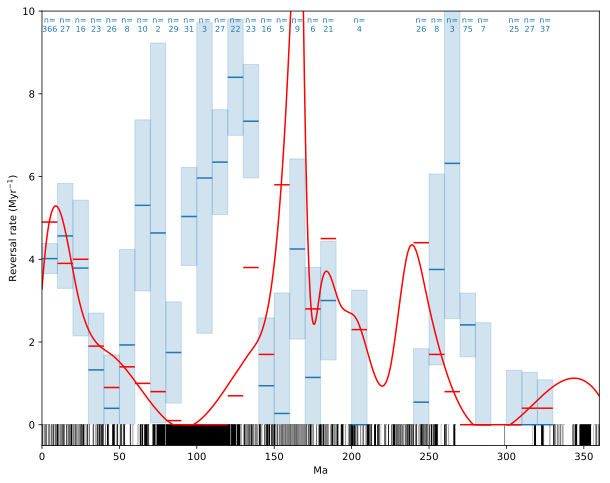

In [8]:
def plot_rev_rate_calc(min_age, max_age, interval, to_use, min_n, figsize=(10,8)):
    plt.figure(figsize=figsize)
    for min_time, max_time in [(i,i+interval) for i in range(min_age,max_age,interval)]:
        pint_avg_time = 1
        ls_num = int((max_time-min_time)/pint_avg_time)

        pint_stat = 0
        for PINT_data in [to_use]:
            if len(PINT_data.loc[PINT_data['AGE']<=max_time].loc[PINT_data['AGE']>=min_time]['VDM/VADM'].values)<min_n:
                continue
            full_mean = np.mean(PINT_data.loc[PINT_data['AGE']<=max_time].loc[PINT_data['AGE']>=min_time]['VDM/VADM'].values)
            full_var = np.var(PINT_data.loc[PINT_data['AGE']<=max_time].loc[PINT_data['AGE']>=min_time]['VDM/VADM'].values)
            sample_number = len(PINT_data.loc[PINT_data['AGE']<=max_time].loc[PINT_data['AGE']>=min_time])
            r_real = len(gpts.loc[gpts['Top (Ma)']>=min_time].loc[gpts['Top (Ma)']<=max_time])/interval
            rev_rate_whole = mf.reversal_rate(full_var, full_mean)
            if pint_stat==0:
                plt.hlines([rev_rate_whole], min_time, max_time, colors='C0')
            else:
                plt.hlines([rev_rate_whole], min_time, max_time, colors='C1')
            rr_err = mf.rev_rate_std(sample_number)
            vertices1 = np.array([[min_time, rev_rate_whole-rr_err], 
                                  [min_time, rev_rate_whole+rr_err], 
                                  [max_time, rev_rate_whole+rr_err], 
                                  [max_time, rev_rate_whole-rr_err]])
            if pint_stat==0:
                poly1 = Polygon(vertices1, color = 'C0', alpha = 0.2,ls=None)
                plt.text((max_time+min_time)/2, 9.5, 
                 'n=\n{}'.format(len(PINT_data.loc[PINT_data['AGE']<=max_time].loc[PINT_data['AGE']>=min_time])), 
                 color='C0', fontsize=8, ha='center')
            else:
                poly1 = Polygon(vertices1, color = 'C1', alpha = 0.2,ls=None)
                plt.text((max_time+min_time)/2, 9, 
                 'n=\n{}'.format(len(PINT_data.loc[PINT_data['AGE']<=max_time].loc[PINT_data['AGE']>=min_time])), 
                 color='C1', fontsize=8, ha='center')
            plt.gca().add_patch(poly1)
            plt.hlines([r_real], min_time, max_time, colors='r')
            pint_stat+=1

    for chron in range(len(gpts)):
        if chron%2==0:
            plt.gca().add_patch(mpatch.Rectangle((gpts['Top (Ma)'][chron], 0), 
                                                 gpts['Duration (myr)'][chron], -1, color='black'))
        else:
            plt.gca().add_patch(mpatch.Rectangle((gpts['Top (Ma)'][chron], 0), 
                                                 gpts['Duration (myr)'][chron], -1, color='white'))

    delta_t = 1
    t = []
    reversals = []
    for reversal_time in range(min_age, max_age+interval, delta_t):
        reversals.append(len(gpts.loc[gpts['Top (Ma)']>=reversal_time].loc[gpts['Top (Ma)']<(reversal_time+delta_t)]))
        t.append(reversal_time)
    spl = sp.interpolate.UnivariateSpline(t,reversals, s=(max_age-min_age)*3)
    ts = np.linspace(0, max(t)+interval,1000)
    plt.plot(ts, spl(ts).clip(0), c='r')
    plt.ylim(-0.5, 10)
    plt.xlim(min_age,max_age+interval)
    plt.ylabel('Reversal rate (Myr$^{-1}$)')
    plt.xlabel('Ma')
    # plt.savefig('code_output/calculations.pdf')
    plt.show()
plot_rev_rate_calc(min_age, max_age, interval, to_use, min_n)

<hr>
## Additional methods of analysis
### Sorting by result type, lithology

The analysis above uses the paleointensity record in bulk, only filtering results by simple parameters of each individual study. Since the reversal rate calculation is determined solely by the mean and the variance of the dipole moment, it is therefore important to also consider other factors—such as lithology, methodology, etc.—that could influence the distribution of combined VDM estimates for any one time period. 

For instance, the mismatch between predicted and observed reversal frequency through the Cretaceous Normal Superchron is a result of the increased variance among VDM estimates within the PINT database for this period, which led to the incorrect prediction of a high reversal frequency. However, it is possible that the highly variable field strength in the Cretaceous as indicated by paleointensity data could be an artifact of grouping data sets that cannot appropriately be compared to each other. 

In [9]:
print(PINT_database.GROUP.unique(), '\n')
# print(PINT_database.TYPE.unique(), '\n')
# print(PINT_database.FORM.unique(), '\n')

['Volcanic' 'Plutonic' nan 'Sedimentary' 'Metamorphic' 'Igneous' 'plutonic'
 'Impact Melt'] 



In [10]:
PINT_igneous = mf.format_PINT(PINT_data_table.loc[PINT_data_table.GROUP.isin(['Volcanic', 'Plutonic', 'Igneous', 'plutonic', 'Impact Melt'])][:])
PINT_sed = mf.format_PINT(PINT_data_table.loc[PINT_data_table.GROUP=='Sedimentary'][:])
PINT_single_crystal = mf.format_PINT(PINT_data_table.loc[PINT_data_table['TYPE'].str.contains('Silicate crystal',na=False)][:])
PINT_intrusive = mf.format_PINT(PINT_data_table.loc[PINT_data_table['GROUP'].str.contains('Plutonic')| 
                                                      PINT_data_table['FORM'].str.contains('Intrusion')][:])
PINT_glass = mf.format_PINT(PINT_data_table.loc[(PINT_data_table['TYPE']=='Glass') |\
                                             (PINT_data_table['FORM'].str.contains('Chilled margin',na=False))][:])
PINT_no_intrusives = mf.format_PINT(PINT_data_table.loc[(PINT_data_table['GROUP'].str.contains('Plutonic')==False) &\
                                                     (PINT_data_table['FORM'].str.contains('Intrusion')==False)][:])
PINT_no_single_crystal = mf.format_PINT(PINT_data_table.loc[(PINT_data_table['TYPE'].str.contains('Silicate crystal')==False)][:])
PINT_no_glass = mf.format_PINT(PINT_data_table.loc[((PINT_data_table['TYPE']=='Glass')==False) &\
                                                     (PINT_data_table['FORM'].str.contains('Chilled margin')==False)][:])
PINT_no_sc_or_glass = mf.format_PINT(PINT_data_table.loc[((PINT_data_table['TYPE']=='Glass')==False) &\
                                                      (PINT_data_table['FORM'].str.contains('Chilled margin')==False) &\
                                                      (PINT_data_table['TYPE'].str.contains('Silicate crystal')==False)][:])
# filter all glass, intrusive, and single crystal data and filter out sedimentary data
PINT_all_filter = mf.format_PINT(PINT_data_table.loc[(PINT_data_table.GROUP.isin(['Volcanic', 'Igneous', 'Impact Melt'])) &\
                                                  ((PINT_data_table['TYPE']=='Glass')==False) &\
                                                  (PINT_data_table['FORM'].str.contains('Chilled margin',na=False)) &\
                                                  (PINT_data_table['TYPE'].str.contains('Silicate crystal')==False) &\
                                                  (PINT_data_table['GROUP'].str.contains('Plutonic')==False) &\
                                                  (PINT_data_table['FORM'].str.contains('Intrusion')==False)][:])

In [11]:
# apply same filters
PINT_igneous_STAT1 = mf.apply_QPI(PINT_igneous, 'stat')
PINT_igneous_ALT1 = mf.apply_QPI(PINT_igneous, 'alt')
PINT_igneous_STAT1_ALT1 = mf.apply_QPI(PINT_igneous, 'stat', 'alt')
PINT_sed_STAT1 = mf.apply_QPI(PINT_sed, 'stat')
PINT_sed_ALT1 = mf.apply_QPI(PINT_sed, 'alt')
PINT_sed_STAT1_ALT1 = mf.apply_QPI(PINT_sed, 'stat', 'alt')
PINT_no_intrusives_STAT1 = mf.apply_QPI(PINT_no_intrusives, 'stat')
PINT_no_intrusives_ALT1 = mf.apply_QPI(PINT_no_intrusives, 'alt')
PINT_no_intrusives_STAT1_ALT1 = mf.apply_QPI(PINT_no_intrusives, 'stat', 'alt')
PINT_no_single_crystal_STAT1 = mf.apply_QPI(PINT_no_single_crystal, 'stat')
PINT_no_single_crystal_ALT1 = mf.apply_QPI(PINT_no_single_crystal, 'alt')
PINT_no_single_crystal_STAT1_ALT1 = mf.apply_QPI(PINT_no_single_crystal, 'stat', 'alt')
PINT_no_glass_STAT1 = mf.apply_QPI(PINT_no_glass, 'stat')
PINT_no_glass_ALT1 = mf.apply_QPI(PINT_no_glass, 'alt')
PINT_no_glass_STAT1_ALT1 = mf.apply_QPI(PINT_no_glass, 'stat', 'alt')
PINT_no_sc_or_glass_STAT1 = mf.apply_QPI(PINT_no_sc_or_glass, 'stat')
PINT_no_sc_or_glass_ALT1 = mf.apply_QPI(PINT_no_sc_or_glass, 'alt')
PINT_no_sc_or_glass_STAT1_ALT1 = mf.apply_QPI(PINT_no_sc_or_glass, 'stat', 'alt')

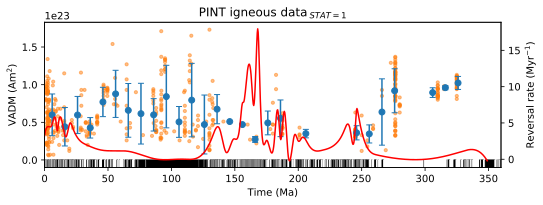

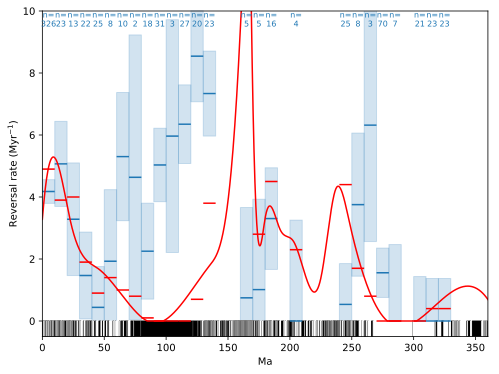

In [12]:
fig, ax1 = plt.subplots(figsize=(8,3))
pint_del_t = 10
for age in range(1, 350, pint_del_t):
    vdms = PINT_igneous_STAT1.loc[(PINT_igneous_STAT1.AGE>=age)&(PINT_igneous_STAT1.AGE<age+pint_del_t)]['VDM/VADM']
    ax1.errorbar(age+(pint_del_t/2), vdms.mean(), yerr=vdms.std(), fmt='o', capsize=3, ecolor='C0')
#     ax1.boxplot(vdms, positions=[age+(pint_del_t/2)], widths=5, sym='x')
ax1.scatter(PINT_igneous_STAT1.loc[PINT_igneous_STAT1.AGE>1.]['AGE'], PINT_igneous_STAT1.loc[PINT_igneous_STAT1.AGE>1.]['VDM/VADM'],c='C1', s=10, alpha=0.5)
ax1.set_ylabel('VADM (Am$^2$)')
ax1.set_xlabel('Time (Ma)')

ax2 = ax1.twinx()
delta_t = 1
t = []
reversals = []
for reversal_time in range(0, 350, delta_t):
    reversals.append(len(gpts.loc[gpts['Top (Ma)']>=reversal_time].loc[gpts['Top (Ma)']<(reversal_time+delta_t)]))
    t.append(reversal_time)
spl = sp.interpolate.UnivariateSpline(t,reversals, s=600)
ts = np.linspace(0, max(t),1000)
ax2.plot(ts, spl(ts), c='r')
ax2.set_ylabel('Reversal rate (Myr$^{-1}$)')

for chron in range(len(gpts)):
    if chron%2==0:
        ax1.add_patch(mpatch.Rectangle((gpts['Top (Ma)'][chron], 0), 
                                             gpts['Duration (myr)'][chron], -1e22, color='black'))
    else:
        ax1.add_patch(mpatch.Rectangle((gpts['Top (Ma)'][chron], 0), 
                                             gpts['Duration (myr)'][chron], -1e22, color='white'))

ax1.set_ylim(-1e22)
plt.xlim(0,max(gpts['Top (Ma)']))
plt.xticks(range(0,360,50), range(0,360,50))
plt.title('PINT igneous data$\,_{STAT=1}$')

# plt.xlim(0,170)

fig.tight_layout()
# plt.savefig('code_output/rev_rate_pint_fig.pdf')
plt.show()
plot_rev_rate_calc(min_age,max_age,interval,PINT_igneous_STAT1,min_n,figsize=(8,6))

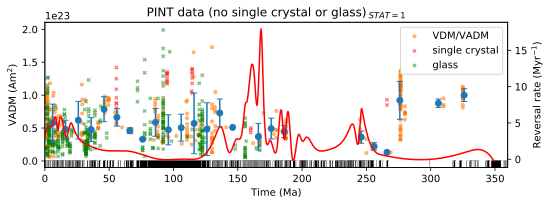

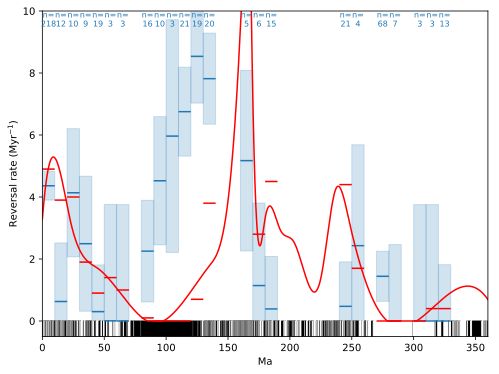

In [13]:
fig, ax1 = plt.subplots(figsize=(8,3))
pint_del_t = 10
for age in range(1, 350, pint_del_t):
    vdms = PINT_no_sc_or_glass_STAT1.loc[(PINT_no_sc_or_glass_STAT1.AGE>=age)&(PINT_no_sc_or_glass_STAT1.AGE<age+pint_del_t)]['VDM/VADM']
    ax1.errorbar(age+(pint_del_t/2), vdms.mean(), yerr=vdms.std(), fmt='o', capsize=3, ecolor='C0')
#     ax1.boxplot(vdms, positions=[age+(pint_del_t/2)], widths=5, sym='x')
ax1.scatter(PINT_no_sc_or_glass_STAT1.loc[PINT_no_sc_or_glass_STAT1.AGE>1.]['AGE'], 
            PINT_no_sc_or_glass_STAT1.loc[PINT_no_sc_or_glass_STAT1.AGE>1.]['VDM/VADM'],
            c='C1', s=10, alpha=0.5)
ax1.scatter(PINT_single_crystal.loc[PINT_single_crystal.AGE>1.]['AGE'], 
            PINT_single_crystal.loc[PINT_single_crystal.AGE>1.]['VDM/VADM'],
            c='r', s=10, alpha=0.5, marker='x', label='single crystal')
ax1.scatter(PINT_glass.loc[PINT_glass.AGE>1.]['AGE'], 
            PINT_glass.loc[PINT_glass.AGE>1.]['VDM/VADM'],
            c='g', s=10, alpha=0.5, marker='x', label='glass')
ax1.set_ylabel('VADM (Am$^2$)')
ax1.set_xlabel('Time (Ma)')

ax2 = ax1.twinx()
delta_t = 1
t = []
reversals = []
for reversal_time in range(0, 350, delta_t):
    reversals.append(len(gpts.loc[gpts['Top (Ma)']>=reversal_time].loc[gpts['Top (Ma)']<(reversal_time+delta_t)]))
    t.append(reversal_time)
spl = sp.interpolate.UnivariateSpline(t,reversals, s=600)
ts = np.linspace(0, max(t),1000)
ax2.plot(ts, spl(ts), c='r')
ax2.set_ylabel('Reversal rate (Myr$^{-1}$)')

for chron in range(len(gpts)):
    if chron%2==0:
        ax1.add_patch(mpatch.Rectangle((gpts['Top (Ma)'][chron], 0), 
                                             gpts['Duration (myr)'][chron], -1e22, color='black'))
    else:
        ax1.add_patch(mpatch.Rectangle((gpts['Top (Ma)'][chron], 0), 
                                             gpts['Duration (myr)'][chron], -1e22, color='white'))

ax1.set_ylim(-1e22)
plt.xlim(0,max(gpts['Top (Ma)']))
plt.xticks(range(0,360,50), range(0,360,50))
plt.title('PINT data (no single crystal or glass)$\,_{STAT=1}$')

# plt.xlim(0,170)
ax1.legend()
fig.tight_layout()
# plt.savefig('code_output/rev_rate_pint_fig.pdf')
plt.show()
plot_rev_rate_calc(min_age,max_age,interval,PINT_no_sc_or_glass_STAT1,min_n,figsize=(8,6))

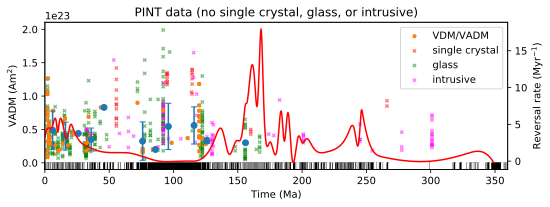

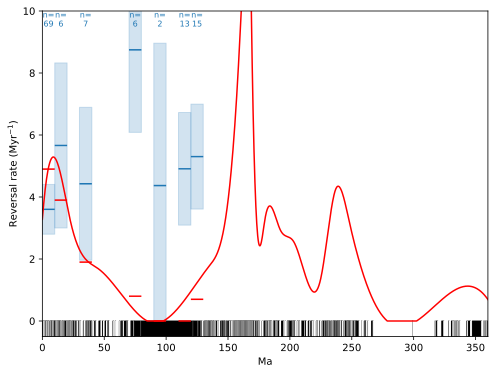

In [14]:
fig, ax1 = plt.subplots(figsize=(8,3))
pint_del_t = 10
for age in range(1, 350, pint_del_t):
    vdms = PINT_all_filter.loc[(PINT_all_filter.AGE>=age)&(PINT_all_filter.AGE<age+pint_del_t)]['VDM/VADM']
    ax1.errorbar(age+(pint_del_t/2), vdms.mean(), yerr=vdms.std(), fmt='o', capsize=3, ecolor='C0', zorder=11)
#     ax1.boxplot(vdms, positions=[age+(pint_del_t/2)], widths=5, sym='x')
ax1.scatter(PINT_all_filter.loc[PINT_all_filter.AGE>1.]['AGE'], 
            PINT_all_filter.loc[PINT_all_filter.AGE>1.]['VDM/VADM'],
            c='C1', s=10, zorder=10)
ax1.scatter(PINT_single_crystal.loc[PINT_single_crystal.AGE>1.]['AGE'], 
            PINT_single_crystal.loc[PINT_single_crystal.AGE>1.]['VDM/VADM'],
            c='r', s=10, alpha=0.5, marker='x', label='single crystal')
ax1.scatter(PINT_glass.loc[PINT_glass.AGE>1.]['AGE'], 
            PINT_glass.loc[PINT_glass.AGE>1.]['VDM/VADM'],
            c='g', s=10, alpha=0.5, marker='x', label='glass')
ax1.scatter(PINT_intrusive.loc[PINT_intrusive.AGE>1.]['AGE'], 
            PINT_intrusive.loc[PINT_intrusive.AGE>1.]['VDM/VADM'],
            c='magenta', s=10, alpha=0.5, marker='x', label='intrusive')
ax1.set_ylabel('VADM (Am$^2$)')
ax1.set_xlabel('Time (Ma)')

ax2 = ax1.twinx()
delta_t = 1
t = []
reversals = []
for reversal_time in range(0, 350, delta_t):
    reversals.append(len(gpts.loc[gpts['Top (Ma)']>=reversal_time].loc[gpts['Top (Ma)']<(reversal_time+delta_t)]))
    t.append(reversal_time)
spl = sp.interpolate.UnivariateSpline(t,reversals, s=600)
ts = np.linspace(0, max(t),1000)
ax2.plot(ts, spl(ts), c='r')
ax2.set_ylabel('Reversal rate (Myr$^{-1}$)')

for chron in range(len(gpts)):
    if chron%2==0:
        ax1.add_patch(mpatch.Rectangle((gpts['Top (Ma)'][chron], 0), 
                                             gpts['Duration (myr)'][chron], -1e22, color='black'))
    else:
        ax1.add_patch(mpatch.Rectangle((gpts['Top (Ma)'][chron], 0), 
                                             gpts['Duration (myr)'][chron], -1e22, color='white'))

ax1.set_ylim(-1e22)
plt.xlim(0,max(gpts['Top (Ma)']))
plt.xticks(range(0,360,50), range(0,360,50))
plt.title('PINT data (no single crystal, glass, or intrusive)')

# plt.xlim(0,170)
ax1.legend()
fig.tight_layout()
# plt.savefig('code_output/rev_rate_pint_fig.pdf')
plt.show()
plot_rev_rate_calc(min_age,max_age,interval,PINT_all_filter,min_n,figsize=(8,6))